<center><h1>Creating a New UMD Dining Hall Nutrition Database and Classifying Vegan Dishes</h1><h4>Brooke Rice, Mitchell Smith</h4></center><hr>

The University of Maryland (UMD) dining halls are famous with students for their occasionally questionable array of sustenance. Trying to find nutrition information for any given meal is also notoriously difficult due to the horrendously arranged online campus dining [database](https://nutrition.umd.edu/). That's why we're making a walkthough of creating an easily searchable dining hall nutrition database and showing how this data can be used to train an is-vegan food classifier. This will be an end-to-end tutorial covering all steps from data acquisition to generalization error estimation. Our key learning objectives are thus as follows...
1. [(web scraping)](#scraping) get necessary nutrition facts from the UMD dining halls website
2. [(data tidying)](#data_tidying) prepare scraped data for interpretation
3. [(data visualization)](#database) create a read-only web database for easily querying nutrition information
4. [(exploratory data analysis)](#eda) examine nutritional contents and compare with health guidelines
5. [(machine learning)](#ml) train an "is vegan" classifier for predicting whether a given dish is vegan based off its nutrition facts
6. [(concluding analysis)](#validation) apply the final classifier to predict generalization loss and draw conclusions

We feel this project is relevant in that we are producing a more accessible and directly useful UMD nutrition search engine while demonstrating the end to end data lifecycle (from data collection to machine learning analysis).
 

#### Aside: dependencies
For the sake of this project, we will be using the [requests library](https://docs.python-requests.org/en/latest/), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), and [Pandas](https://pandas.pydata.org/docs/) to scrape and store data. We will create plots using [matplotlib](https://matplotlib.org/) and [graphviz](https://github.com/xflr6/graphviz). A searchable UI will be prepared using [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/), and machine learning will be performed using [scikit-learn](https://scikit-learn.org/stable/). Nutrition data will be sourced from https://nutrition.umd.edu/, and our generalization estimation set will come from [Kaggle](https://www.kaggle.com/trolukovich/nutritional-values-for-common-foods-and-products). 

<a id=scraping></a>
# Scraping the UMD dining hall nutrition data
### Section 1: Collecting nutrition links
Before jumping straight into the scraping code, check out https://nutrition.umd.edu/. After a couple clicks, you might notice that the UMD dining hall web pages attempt to display a dynmaic meal page based off the query date. Since we want our database to function regardless of the current date, we can start our search from the base page for the South Campus Dining Hall (without providing any datetime information). We can then automatically pick up on the current day's meal information by grabbing each meal's current weblink (see [footnote](#footnote) for the case that the website has gone offline or the dining halls are currently closed).

After taking care of the dynamic date query aspect, we are free to start pulling information about the foods provided for each meal (breakfast, lunch, and dinner). Each individual food item link will lead us to the nutrition facts label that we want, but these label pages do not list whether a dish is vegetarian! Instead, whether or not a food item is vegan, vegetarian, gluten free, et cetera is listed on the corresponding meal page next to each item's nutrition label link.

Because of this, we need to manually iterate through the food items table (as opposed to grabbing all relevant links with a single call to find_all()) and record the separate information about whether a dish is vegetarian or vegan. We can then cycle through each meal to copy all of our desired nutrition label links. Note that we only want to collect unique links because certain foods may be served across multiple meals. To that end, we can use a set for link storage to avoid duplicate scraping.

In [1]:
# import standard html scraping libraries
from bs4 import BeautifulSoup
import requests

# declare base link (used in most of the site's hyperlinks)
baseSite = 'https://nutrition.umd.edu/'

# request dining hall nutrition webpage from minimized URL
r = requests.get(f'{baseSite}shortmenu.aspx?locationNum=16&naFlag=1')
htmlTree = BeautifulSoup(r.content)

# find links to each of breakfast, lunch, and dinner menu pages
mealLinks = [baseSite + str(link['href']) 
             for link in htmlTree.find_all('a', href=True)
             if 'meal' in str(link)]

# combine meal names with weblinks for clarity
mealNames = ['breakfast', 'lunch', 'dinner']

# note that there is no breakfast on sundays...
mealNames = mealNames[1:] if len(mealLinks) < 3 else mealNames
mealPages = list(zip(mealNames, mealLinks))

# prepare output structure for storing food links
nutritionLinks = []

# note that there is overlap betw meals for some food items, so use a set to avoid duplication
prevWork = set()

# and record food table HTML attributes for ease of scraping
tableAttributes = {"align":"center", "border":"1", "width":"70%", "cellspacing":"0", 
                   "cellpadding":"0", "bordercolor":"gray", "bgcolor":"#FFFFFF"}

# get nutrition information on a meal by meal query basis
for mealPage in mealPages:
    # print basic information about each meal page
    print(f'{mealPage[0]}: {mealPage[1]}')
    # query each meal page for food item elements
    r = requests.get(mealPage[1])
    htmlTree = BeautifulSoup(r.content)
    # vegetarian information is provided next to nutrition link in table
    table = htmlTree.find_all('table', attrs=tableAttributes)[0]
    tableRows = table.find_all('tr')
    # so loop through all table entries
    foodLinks = []
    for entry in tableRows:
        # and skip those entries which do not contain a food link
        if 'href' not in str(entry) or 'RecNumAndPort' not in str(entry):
            continue
        # get actual nutrition label link
        link = [str(link['href'])
                for link in entry.find_all('a', href=True)
                if 'RecNumAndPort' in str(link)][0]
        link = baseSite + link
        # do not reprocess duplicates!
        if link in prevWork:
            continue
        prevWork.add(link)
        # record whether the food is vegetarian
        vFlags = []
        if 'vegetarian' in str(entry):
            vFlags.append(True)
        else:
            vFlags.append(False)
        # as well as whether it is vegan
        if 'vegan.gif' in str(entry):
            vFlags.append(True)
        else:
            vFlags.append(False)
        # and of course record the link itself!
        vFlags.append(link)
        # then add current data tuple to our nutrition labels hyperlink set
        foodLinks.append(vFlags)
    # store links in output dict
    nutritionLinks.extend(foodLinks)

lunch: https://nutrition.umd.edu/longmenu.aspx?sName=&locationNum=16&locationName=&naFlag=1&WeeksMenus=This+Week%27s+Menus&dtdate=12%2f18%2f2021&mealName=Lunch
dinner: https://nutrition.umd.edu/longmenu.aspx?sName=&locationNum=16&locationName=&naFlag=1&WeeksMenus=This+Week%27s+Menus&dtdate=12%2f18%2f2021&mealName=Dinner


<a id="footnote1"></a>
NOTE: because the dining halls close over break, it is entirely possible that you will NOT be able to get meal information outside of Fall and Spring semesters! If you would like to continue with this tutorial while the site is down, please download our previously generated database file from [here](https://github.com/harlansgs/fall-2021-umd-dining-analysis/blob/main/umd_nutrition.pkl) and skip to the [Data tidying](#data_tidying) section. You can then load the uncleaned dataframe prior to continuing by loading the downloaded pickle file as follows...
```python
df = pandas.read_pickle("downloadedFile")
```

### Section 2: collecting nutrition information
To actually get our nutrition data, we need to query each individual food item's nutrition label page. We can start by declaing the nutrition facts we want to grab for our new database, and then we can scrape for each of the desired nutrition label elements on a per-food-item basis. 

The nutrition facts are stored in nested HTML tables using span tags, so with a bit of string parsing we can pull them directly from each food item's span tag set. We do have to grab the food name and serving size separately since they are stored in different tables. We should also keep in mind that there are a handful of food items with no nutrition data (mostly vegan dishes), so we should be careful not to query them for data which doesn't exist.

After rendering each individual nutrition fact, we can append it to the dataframe we declared earlier (loading all of the pre-defined target nutrition facts). Since this is a lengthy process and we have no gaurantee that the dining hall's websites will maintain the same format forever, we should go ahead and save our final dataframe to a pickle file for safe keeping. This will allow us to continue performing analysis and hosting nutrition data even after the dining hall webpages go offline. It's also worth noting that the nutrition data above is for a single serving of the corresponding food item (which might be measured in ounces or in numbers of the food item itself).

In [2]:
# import pandas so that we can create a nutrition dataframe
import pandas as pd

# declare nutrition dataframe and desired information
stats = ['Total Fat', 'Total Carbohydrate.', 'Saturated Fat', 'Dietary Fiber', 'Trans Fat',
         'Total Sugars', 'Cholesterol', 'Sodium', 'Protein', 'Calories', 'Carbohydrates', 
         'Vitamin C', 'Allergens', 'Is Vegetarian', 'Is Vegan', 'Serving Size', 'Food']
df = pd.DataFrame(columns=stats)

# integer for getting unique indices
entryNum = 0

# structure for recording the handful of foods with no nutrition information
missingInfo = {}

# iterate through each meals nutrition links
for vegetarianFlag, veganFlag, link in nutritionLinks:
    # query each food item's nutrition page
    r = requests.get(link)
    htmlTree = BeautifulSoup(r.content)
    # grab title of food item
    title = htmlTree.find('div', {"class":"labelrecipe"}).contents[0]
    # edge case: certain vegan foods do not have nutrition information!
    if (len(htmlTree.findAll('div', {"class":"labelnotavailable"})) != 0):
        missingInfo[title] = link
        continue
    # else, grab serving size 
    servingSize = htmlTree.findAll('div', {"class":"nutfactsservsize"})[1].contents[0]
    # collect allergens
    allergens = htmlTree.findAll('span', {"class":"labelallergensvalue"})[0].contents
    allergens = allergens[0] if len(allergens) > 0 else ""
    # then get misc. nutrition facts from webpage
    rawNutritionFacts = htmlTree.find_all('span', {"class":"nutfactstopnutrient"})
    # format nutrition information
    nutritionFactsList = [['Allergens', allergens], ['Is Vegetarian', vegetarianFlag], ['Is Vegan', veganFlag],\
                          ['Food', str(title)], ['Serving Size', servingSize]]
    # remove HTML format specifiers from string data
    for fact in rawNutritionFacts:
        fact = list(filter(lambda str: len(str) != 0, fact.text.split('\xa0')))
        if (len(fact) == 2):
            nutritionFactsList.append(fact)
    nutritionFacts = dict(nutritionFactsList)
    # create new dataframe entry for current food item
    df.loc[entryNum] = nutritionFacts
    # and increment entry num
    entryNum += 1
    
# save dataframe to pickle file!
df.to_pickle('new_umd_nutrition.pkl')
    
# return resultant dataframe
df

,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Trans Fat,Total Sugars,Cholesterol,Sodium,Protein,Calories,Carbohydrates,Vitamin C,Allergens,Is Vegetarian,Is Vegan,Serving Size,Food
0,18.2g,0g,7.1g,0g,0.8gram,0g,63.4mg,467.7mg,15.1gram,222.8kcal,0gram,0mg,,False,False,1 each,Beef Burger
1,23g,0g,9.8g,0g,0.8gram,0g,80.3mg,358.1mg,18.4gram,276.8kcal,0gram,0mg,Milk,False,False,1 each,Cheddar Burger
2,1.6g,3.2g,0g,0g,0gram,2.1g,31.8mg,265.3mg,7.4gram,53.1kcal,3.2gram,0mg,,False,False,1 ea,Cranberry Chicken Sausage Breakfast
3,5.2g,25.1g,2.1g,2.7g,0gram,1.4g,0mg,144mg,2.8gram,162.3kcal,25.1gram,7.2mg,,True,True,4 oz,Garlic Herb Roasted Yukon Gold Potatoes
4,4.4g,1.7g,0.4g,0.2g,0gram,0.1g,0.2mg,19mg,0.4gram,46.9kcal,1.7gram,1.4mg,Milk,False,False,1 each,Grilled Basil Pesto Chicken Breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,3.8g,11.6g,1.5g,2g,0gram,1.1g,0mg,94.4mg,3.3gram,89.3kcal,11.6gram,73.5mg,"Wheat, Soybeans",True,True,4 oz,Italian Herb Crushed Red Pepper Broccoli
316,27.8g,78.4g,13.3g,6.9g,0gram,2.9g,0mg,1632.7mg,12.7gram,609.1kcal,78.4gram,10.4mg,Wheat,True,True,1 each,Mushroom Carmelized Onion Quesadilla
317,6g,3.9g,0.8g,1.3g,0gram,0.3g,0mg,243.5mg,10.7gram,102.3kcal,3.9gram,7.1mg,"Wheat, Soybeans, Sesame",True,True,4 oz,Spicy Hunan Steamed Tofu
318,0.3g,18.9g,0g,8.6g,0gram,1.1g,0mg,63.3mg,7.7gram,107.9kcal,18.9gram,4.4mg,,True,True,3 oz,Spinach Chunky Tomato Lentils


<a id='data_tidying'></a>
# Data tidying: cleaning the nutrition data
After some poking around in the dataframe, we noticed that there are a handful of nutrition labels which simply drop nutrients that were not part of the corresponding food item (ie: grilled hotdogs do not include an entry for dietary fiber). We likewise need to account for NaN values by replacing them with a 0. We can also convert our string measurements into floats to simplify data analysis. To that end, we should grab our measurement units and store them elsewhere for later reference.

We do NOT explicitly convert serving size because it is not provided with consistent units. By this we mean that most food items have their servings measured in ounces, but others are measured in terms of individual food objects. We also leave the food name, "Is Vegetarian", and "Is Vegan" columns as-is since they are inherently non-numeric.

In [3]:
# import regex for string parsing
import re

# load previously scraped database for the sake of this tutorial
df = pd.read_pickle('umd_nutrition.pkl') # see footnote for more up-to-date information

# record units used for nutrition measurements
units = dict(zip(stats, ['grams', 'grams', 'grams', 'grams', 'grams', 'grams', 
                         'milligrams', 'milligrams', 'grams', 'kcal', 'grams', 'milligrams', 
                         'N/A', 'N/A', 'N/A', 'N/A', 'N/A']))

# certain foods have duplicate entries (variable serving sizes) in the database (ie. pork enchiladas), so remove duplicates
df.drop_duplicates(subset=['Food'], inplace=True)

# clean NaNs
toUpdate = {}
# NaNs indicate that the label did not include a nutrient (b/c the food has none, ie. hotdogs and fiber)
for idx,row in df.iterrows():
    numNans = len([entry for entry in row if str(entry).lower() == 'nan'])
    newRow = [entry if str(entry).lower() != 'nan' else "0" for entry in row]
    if numNans != 0:
        toUpdate[idx] = newRow

# so replace NaNs with 0!
for idx,row in toUpdate.items():
    df.loc[idx] = row
        
# define function to convert string measurement to numeric
def convertToNumeric(string):
    try:
        # when re-running code, do not erase pre-converted values!
        return float(re.sub(r'[a-zA-Z]', '', string)) if type(string) == type("") else string
    except:
        # some labels drop missing nutrients
        return float(0)

# then update columns to reflect their numeric counterparts
for colName in df.columns:
    # do not convert inherently non-numeric columns!
    if (colName == "Food" or colName == "Serving Size" or colName == "Is Vegetarian"\
        or colName == "Is Vegan" or colName == "Allergens"):
        newCol = df[colName]
    else: 
        newCol = [convertToNumeric(measurement) for measurement in df[colName]]
    # explicitly drop and re-add column in order to avoid issues with shallow copying
    df = df.drop(columns=[colName])
    df[colName] = newCol

# return updated dataframe
df

,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Trans Fat,Total Sugars,Cholesterol,Sodium,Protein,Calories,Carbohydrates,Vitamin C,Allergens,Is Vegetarian,Is Vegan,Serving Size,Food
0,21.2,0.0,7.6,0.0,0.0,0.0,45.4,997.9,15.1,241.9,0.0,0.0,,False,False,2 ea,Bacon
1,3.8,15.9,1.9,0.4,0.0,4.2,9.2,284.0,1.9,107.5,15.9,0.0,"Milk, Eggs, Wheat, Soybeans",True,False,1 ea,Pancakes Plain
2,22.3,0.0,14.2,0.0,0.0,0.0,60.8,0.0,0.0,202.5,0.0,0.0,Milk,True,False,1 oz,Butter
3,0.0,15.0,0.0,0.0,0.0,14.4,0.0,66.4,0.0,57.8,15.0,0.0,,True,True,1 oz,Maple Syrup
4,22.3,0.0,10.1,0.0,0.0,0.0,0.0,212.6,0.0,202.5,0.0,0.0,Soybeans,True,True,1 oz,Margarine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1.3,121.6,0.5,17.2,0.0,39.5,0.0,196.6,9.5,525.2,121.6,0.0,,True,True,1 each,Baked Sweet Potato
336,12.2,21.4,0.0,3.1,0.0,0.0,0.0,473.1,19.8,259.4,21.4,0.0,"Wheat, Soybeans",True,True,1 each,Breaded Chicken Cutlet
337,1.4,12.7,0.1,2.5,0.0,0.0,0.0,101.2,0.8,59.8,12.7,0.0,,True,True,3 oz,Lemon Pepper Roasted Yellow Squash
338,3.6,8.6,0.9,0.9,0.0,0.1,0.0,148.6,0.9,70.3,8.6,0.9,Soybeans,True,True,4 oz,Tater Tots


Note that we have chosen to use a Pandas dataframe for data storage. We reccommend using Pandas for these tasks because:
1. Pandas makes tabular data representation incredibly easy (fast queries, updates, column additions, reindexing, filtering, basic statistics, etc)
2. Pandas has incredible support across the industry (as it is the de facto standard for tabular data, we can automatically interface with HTML sources, output to SQL, interface with numpy and scipy, scikit-learn and statsmodels integrations, etc)

<a id="footnote2"></a>
NOTE: we chose to load pre-scraped data at the beginning of this section for the sake of the tutorial. Having consistent meal options irrespective of current dining hall schedules makes it easier for us to provide precise examples and ascertain consistent model performance. If you are following along and would like to use more up-to-date nutriton facts, please change the indicated line from the above codeblock as follows...
```python
df = pandas.read_pickle('umd_nutrition.pkl') # uses backup data
```
Should become:
```python
df = pandas.read_pickle('new_umd_nutrition.pkl') # uses newly scraped data
```

<a id="database"></a>
# Data visualization: creating a read-only web database
At this point in the process, we have already acquired and cleaned the desired nutrition data. With the backing dataset more or less complete, creating a database becomes trivial. For our purposes, we only want the ability to read nutrition data. Only UMD dining hall workers should be able to create, update, or delete menu items. That said, to create a read-only interface for our nutrition data, we would typically recommend [bamboolib](https://bamboolib.8080labs.com/). It's the perfect tool for this sort of thing, yet we will be creating our own interface with [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) for ease of HTML hosting.

Libraries aside, we want our new nutrition database to function just like UMD's: we should be able to query for whatever food we desire (by name) and get a quick nutrition facts sheet with allergens listed. To that end, we will need to define a simple string search for finding close food matches (ie. "fwench" should find "French Toast") as well as a label generation method (for outputting nutrition information). We then want to design our interface to make use of these functions for an easily searchable nutrition dataset.

In [29]:
# import widgets library
import ipywidgets as widgets
from IPython.display import display, clear_output
# import difflib for finding close string matches
import difflib

### QUERY LOGIC ###
# create a simple search function (returns indices of similarly named foods)
def searchDataframe(foodName):
    indices = []
    # try getting close matches with difflib
    possibleMatches = difflib.get_close_matches(foodName, df['Food'].str.lower())
    # if unsuccessful, manually search for food name in food set
    if len(possibleMatches) == 0:
        # look for decreasingly small substrings of input name in dataset
        for i in range(0,len(foodName)):
            currSubString = foodName[i:len(foodName)].lower()
            possibleMatches = [food for food in df['Food'].str.lower()
                               if currSubString in food]
            # break when a match is found
            if len(possibleMatches) != 0:
                break
            # try it in reverse as well
            currSubString = foodName[0:len(foodName) - i].lower()
            possibleMatches = [food for food in df['Food'].str.lower()
                               if currSubString in food]
            # break when a match is found
            if len(possibleMatches) != 0:
                break
    # then return the indices of possible matches (or an empty list if no match found)
    return [df.index[df.Food.str.lower() == m] for m in possibleMatches]
    
### LABEL GENERATION / PRETTY PRINT ###
# pretty print method for creating nutrition labels from a dataframe index
def getLabel(index):
    # get the corresponding row
    row = df.loc[index]
    # change index to the food name, and drop the food name entry
    row.index = row["Food"]
    row = row.drop(columns=["Food"])
    # then format each nutrition fact with proper units
    label = pd.DataFrame()
    for nutrient in row.columns:
        # do not reformat serving size or allergens strings!
        if nutrient == "Serving Size" or nutrient == "Allergens":
            label[nutrient] = row[nutrient][0]
        # do convert vegetarian flag -> yes or no
        elif nutrient == "Is Vegetarian" or nutrient == "Is Vegan":
            label[nutrient] = "Yes" if row[nutrient][0] else "No"
        # and do add units to numeric data
        else:
            label[nutrient] = pd.Series(f"{str(row[nutrient][0])} {str(units[nutrient])}")
    # set the food name and return!
    label.index = row.index
    return label
    
### USER INTERFACE ###
# create a search button
searchButton = widgets.Button(description="search")

# create a simple textbox for querying for food items
strIn = widgets.Text(
    placeholder='search for foods',
    disabled=False
)

# group search button + text input
searchWidg = widgets.Box([strIn, searchButton])
display(searchWidg)

# create a text output region for returning query results
strOut = widgets.Text(
    placeholder='(query results)',
    disabled=False
)
    
# define click event for searching
output = widgets.Output()
@output.capture()
def on_button_clicked(init):
    # clear previous output, find possible food matches
    clear_output()
    possibleMatchIndices = searchDataframe(strIn.value)
    # pretty print nutrition labels for each
    for index in possibleMatchIndices:
        display(getLabel(index).T)
            
# link search button to click event
searchButton.on_click(on_button_clicked)
widgets.interact(searchButton)
display(output)

Box(children=(Text(value='', placeholder='search for foods'), Button(description='search', style=ButtonStyle()…

interactive(children=(Output(),), _dom_classes=('widget-interact',))

Output()

We would argue that the above search box is far more convenient than looking for any given food item's nutrition information on https://nutrition.umd.edu/. That said, we realize that a search box alone is not a full-fledged database. For the sake of this tutorial we will briefly demonstrate the creation of a proper SQL database using the previously recorded nutrition information.
## Aside: Creating a true CRUD database
A true database should implement Create, Read, Update, and Delete behavior (the CRUD standard). Since we chose to represent our data using a dataframe, we can make use of Pandas "to_sql()" method in order to create a Structured Query Language (SQL) database from our nutrition records. SQL is a common programming language for working with relational databases with many popular offshoots like SQLite and PostgreSQL, but we won't be diving too deep for the sake of this demonstration. Please refer to Usman Malik's [tutorial](https://realpython.com/python-sql-libraries/) if you would like to learn more about working with SQL in python. A simple example of creating a database and querying for cheeseburgers can be found below: 

In [5]:
# import sqlite libs for easy sql processing in python
import sqlite3

# create a new database for nutrition data
conn = sqlite3.connect('nutrition_database')
c = conn.cursor()

# then load our nutrition data into the database, populating a new SQL table named "facts"
df.to_sql('facts', conn, if_exists='replace', index = False)

# and issue a test query for burgers
c.execute('''  
            SELECT * FROM facts
            WHERE Food LIKE '%Burger%'
          ''')

# print results!
for row in c.fetchall():
    print(row)

(18.2, 0.0, 7.1, 0.0, 0.8, 0.0, 63.4, 467.7, 15.1, 222.8, 0.0, 0.0, '', 0, 0, '1 each', 'Beef Burger')
(22.8, 0.5, 9.7, 0.0, 0.8, 0.0, 73.6, 445.9, 18.1, 278.5, 0.5, 0.0, 'Milk, Soybeans', 0, 0, '1 each', 'Cheeseburger with American Cheese')
(1.9, 26.8, 0.4, 1.5, 0.0, 2.2, 0.0, 245.8, 4.5, 134.1, 26.8, 0.0, 'Wheat, Soybeans', 1, 1, '1 each', 'Potato Hamburger Roll')
(7.2, 24.2, 0.9, 0.0, 0.0, 3.6, 0.0, 727.2, 10.8, 197.5, 24.2, 0.0, 'Wheat', 1, 1, '1 each', '3 Grain Corn Black Bean Burger')


/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


<a id="eda"></a>
# Exploratory data analysis: too much sugar and sodium?

The FDA's dietary guidelines recommend consuming no more than [2,300 mg of sodium](https://www.fda.gov/food/food-additives-petitions/sodium-reduction) a day. For men with a 2,000 calorie diet, the American Heart Association recommends no more than [36 grams of sugar](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.109.192627) per day. That being said, the UMD dining halls have to produce food en masse for the student body. With more than [30,000](https://research.umd.edu/about/facts-figures) undergraduate students, the University has to order frozen foods in bulk in order to feed everyone. These mass-produced foods are notorious for high sodium and sugar contents, so let's how the worst stack up to daily reccomendations...

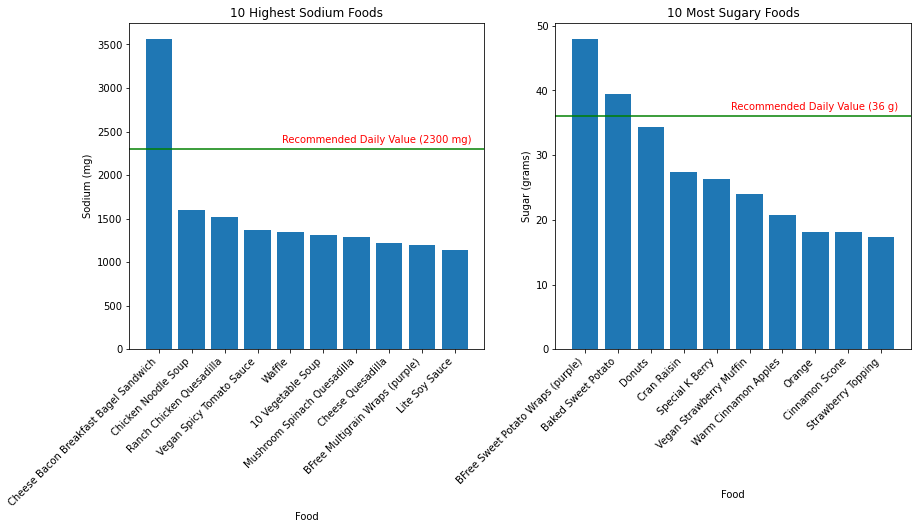

In [6]:
# Get plotting libs
import matplotlib.pyplot as plt

# Grab the 10 highest sodium-content and sugar-content foods
mostSodium = df.nlargest(10, ['Sodium'])
mostSugar = df.nlargest(10, ['Total Sugars'])

# Declare intake limit vars
recSodiumPerDay = 2300
recSugarPerDay = 36

# Prepare output plot panel
fig = plt.figure(figsize=(14, 6))

# Create sodium content bar graph
ax = fig.add_subplot(1, 2, 1)
ax.bar(mostSodium["Food"], mostSodium["Sodium"])
ax.title.set_text('10 Highest Sodium Foods')
ax.set_ylabel('Sodium (mg)')
ax.set_xlabel('Food')

# Add expected sodium daily value line, adjust labels
ax.text(9.5, 2400, "Recommended Daily Value (2300 mg)", color="red", ha='right', va='center')
plt.axhline(y = 2300, color = 'green')
plt.xticks(rotation=45, ha='right')

# Create sugar content bar graph
ax = fig.add_subplot(1, 2, 2)
ax.bar(mostSugar["Food"], mostSugar["Total Sugars"])
ax.title.set_text('10 Most Sugary Foods')
ax.set_ylabel('Sugar (grams)')
ax.set_xlabel('Food')

# Add expected sugar daily value line, adjust labels
ax.text(9.5, 37.5, 'Recommended Daily Value (36 g)', color="red", ha='right', va='center')
plt.axhline(y = 36, color = 'green')
plt.xticks(rotation=45, ha='right')

# Render plots!
plt.show()

As shown in the above graph, it is possible to exceed the reccomended daily amount of sodium and sugar intake with just two servings of dining hall food! Mixing and matching two of any of the 10 saltiest foods would put a student over the daily limit, yet two servings of the chicken noodle soup wouldn't even add up to 400 calories (leaving students to fill in the rest of their 2,000 calorie a day diet with an ideally negative portion of sodium). Sugar appears to be equally difficult to work around, but we can't say whether this pattern holds for the whole dataset just yet! 
## Plotting daily values vs. food contents
With some evidence to support that there may be far too much sugar and sodium in the average dining hall dish, let's try to see how the entire database stacks up against recommended daily values. To that end, we can compute the average nutrient content for each food in our database. We can then create a bar for the percent daily value provided by each food, and place these bars in terms of how many grams/milligrams each food was above or below the average nutrient content. To simplify the process, we can write a generic plotting function and call it with our recommended daily value for each nutrient. 

For the reference data, we sourced the following daily values from [usda.gov](https://www.fda.gov/food/new-nutrition-facts-label/daily-value-new-nutrition-and-supplement-facts-labels):
- Calories      2,000kCal
- Carbohydrate       275g
- Cholesterol       300mg
- Dietary Fiber 	  28g
- Protein 	          50g
- Saturated fat   	  20g
- Sodium           2300mg
- Total fat           78g
- Total sugars (AHA)  36g
- Vitamin C          90mg

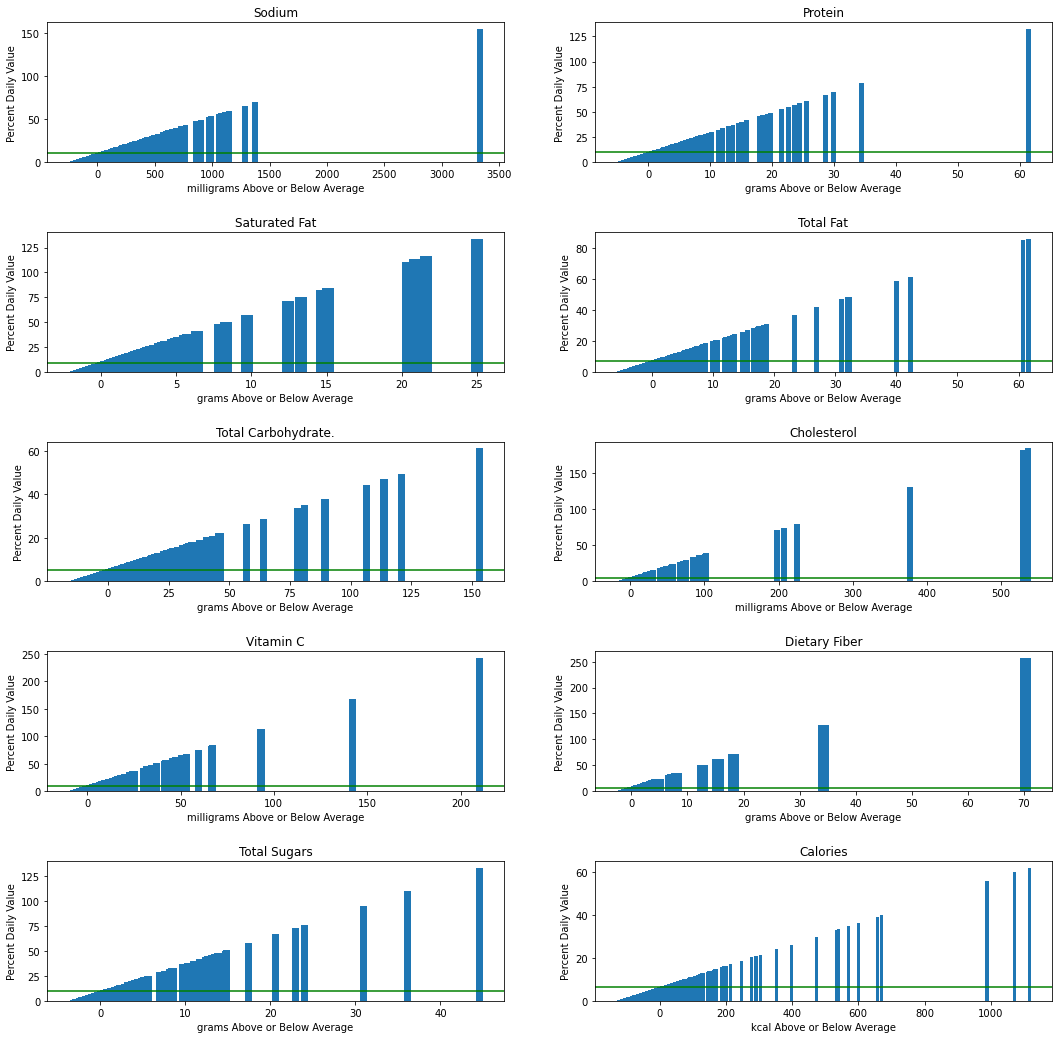

In [7]:
# prepare output plot template for organizing graphgs
fig = plt.figure(figsize=(18,18))

# declare expected daily amounts dictionary
stats = ['Total Fat', 'Total Carbohydrate.', 'Saturated Fat', 'Dietary Fiber', 'Trans Fat',
        'Total Sugars', 'Cholesterol', 'Sodium', 'Protein', 'Calories', 'Carbohydrates', 
        'Vitamin C', 'Allergens', 'Is Vegetarian', 'Is Vegan', 'Serving Size', 'Food']

# put a -1 for trans fat as we could not find a recommended daily value!
dailyVal = dict(zip(stats, [78, 275, 20, 28, -1, 36, 300, 2300, 50, 
                            2000, 275, 90, -1, -1, -1, -1, -1, -1]))

# prepare generic function for plotting
def plotNutrientResidualAndDailyValue(graphPosition, nutrient, widthOfBar):
    # get recommended daily amount for current nutrient
    recDailyAmount = dailyVal[nutrient]
    # get plotting frame from input graph positions
    ax = fig.add_subplot(graphPosition[0], graphPosition[1], graphPosition[2])
    averageContent = df[nutrient].mean()
    # plot grams above / below average vs percent daily values
    if widthOfBar is not None: 
        ax.bar(df[nutrient] - averageContent, (df[nutrient] / recDailyAmount) *100, width = widthOfBar)
    else:
        ax.bar(df[nutrient] - averageContent, (df[nutrient] / recDailyAmount) *100)
    # and plot the average daily value line across all food data
    plt.axhline((averageContent / recDailyAmount) * 100, color = 'green')
    # set relevant labels for interpretation
    ax.title.set_text(nutrient)
    ax.set_xlabel(f'{units[nutrient]} Above or Below Average')
    ax.set_ylabel('Percent Daily Value')

# prepare sodium plot: get plot frame and average sodium value
plotNutrientResidualAndDailyValue((5, 2, 1),  'Sodium', 50)
       
# repeat same process for all other nutrients...
plotNutrientResidualAndDailyValue((5, 2, 2),  'Protein', None)
plotNutrientResidualAndDailyValue((5, 2, 3),  'Saturated Fat', None)
plotNutrientResidualAndDailyValue((5, 2, 4),  'Total Fat', None)
plotNutrientResidualAndDailyValue((5, 2, 5),  'Total Carbohydrate.', 3)
plotNutrientResidualAndDailyValue((5, 2, 6),  'Cholesterol', 8)
plotNutrientResidualAndDailyValue((5, 2, 7),  'Vitamin C', 4)
plotNutrientResidualAndDailyValue((5, 2, 8),  'Dietary Fiber', 2)
plotNutrientResidualAndDailyValue((5, 2, 9),  'Total Sugars', None)
plotNutrientResidualAndDailyValue((5, 2, 10), 'Calories', 10)

# set spacing between rows of plots!
plt.subplots_adjust(hspace = .5)

Looking at these results, we can see that there is a large variance in what percent daily value a student can expect to receive (for any given nutrient) from each food item. Where a single serving could get you as much as 250% of your daily vitamin C, you can only get about 60% of your carbs in one go. That said, the average daily value for each nutrient also varies greatly. A student can expect to get about 10% of their daily fiber from a single serving of any random food item but only 5% of their daily cholesterol. Before delving further into classification efforts, let's look at the stats directly to see whether the high-sodium and sugar cases were just outliers...

In [8]:
# prepare a function for generating nutrition stats summaries
def getNutritionStats(subset):
    # declare a new dataframe for the output statistics chart
    chart = pd.DataFrame()
    
    # then loop through each nutrient to generate statistics
    for nutrient in subset.columns:
        # do not include nutrients which we do not have a reference for!
        if nutrient == "Trans Fat" or nutrient == "Carbohydrates" or \
           nutrient == "Serving Size" or nutrient == "Allergens" or \
           nutrient == "Is Vegetarian" or nutrient == "Is Vegan" or \
           nutrient == "Food":
            # note that we also exclude carbs because the recommended amt betw carbs and total carbs is equivalent
            continue
        # for all other nutrients, compute average food content
        avgContent = subset[nutrient].mean()
        # get variance of nutrient content
        contentVariance = subset[nutrient].std()
        # as well as average daily value
        avgDailyValue = (avgContent / dailyVal[nutrient]) * 100
        # and record chart entry
        chart[nutrient] = [units[nutrient], dailyVal[nutrient], avgContent, contentVariance, avgDailyValue]
    
    # rename indices per computed statistic, and return result!
    chart = chart.set_axis(['Units', 'Rec. Daily Value (units)', 'Average Content (units)', \
                            'Content Standard Deviation (units)', 'Average Daily Value %'], axis = 'index')
    return chart

# get overall nutrition statistics
getNutritionStats(df)

,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Total Sugars,Cholesterol,Sodium,Protein,Calories,Vitamin C
Units,grams,grams,grams,grams,grams,milligrams,milligrams,grams,kcal,milligrams
Rec. Daily Value (units),78,275,20,28,36,300,2300,50,2000,90
Average Content (units),5.55697,14.9234,1.78635,1.74629,3.38872,15.1849,230.778,4.80415,127.232,8.28576
Content Standard Deviation (units),8.71133,21.9314,3.70321,4.82595,5.9314,54.4847,350.602,7.46312,160.891,25.1203
Average Daily Value %,7.12432,5.42671,8.93175,6.23675,9.41312,5.06162,10.0338,9.60831,6.3616,9.2064


When taken as a whole, the average sodium content of any given diner food isn't too terrible (at about 10% of the daily recommended value), but there is a very high standard deviation (of <u>+</u>15.2%). It would likewise be a good idea to carefully consider your options when choosing between any two food items seeing that one could contain as much as 500mg more sodium than the other. 

Average sugar content similarly sits around 9.4% of the recommended daily value with a standard deviation of <u>+</u>16.5% DV. General statements about a high sodium or sugar content are hence difficult to prove, but perhaps we can start to see trends when we categorize the data...

<a id="stats"></a>
## Vegan or not: nutritional differences
With our original goal being to train a classifier for seeing whether or not a given food is vegan, it is a good idea to try breaking down our percent daily value statistics on a what-is and what-isn't vegan basis. We could then examine the averages, variance, and et cetera directly...

In [9]:
# get statistics for non-vegan food items
print("Non-vegan food stats...")
nonVeganStats = getNutritionStats(df[df['Is Vegan'] == False])
nonVeganStats

Non-vegan food stats...


,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Total Sugars,Cholesterol,Sodium,Protein,Calories,Vitamin C
Units,grams,grams,grams,grams,grams,milligrams,milligrams,grams,kcal,milligrams
Rec. Daily Value (units),78,275,20,28,36,300,2300,50,2000,90
Average Content (units),9.40963,15.8607,3.5,1.04667,3.36741,37.643,331.773,8.25704,177.102,4.13556
Content Standard Deviation (units),11.2885,23.9115,5.07794,1.90144,5.23538,81.1912,435.944,9.84801,192.952,9.44993
Average Daily Value %,12.0636,5.76754,17.5,3.7381,9.35391,12.5477,14.4249,16.5141,8.85511,4.59506


In [10]:
# get statistics for vegan food items
print("Vegan food stats...")
veganStats = getNutritionStats(df[df['Is Vegan'] == True])
veganStats

Vegan food stats...


,Total Fat,Total Carbohydrate.,Saturated Fat,Dietary Fiber,Total Sugars,Cholesterol,Sodium,Protein,Calories,Vitamin C
Units,grams,grams,grams,grams,grams,milligrams,milligrams,grams,kcal,milligrams
Rec. Daily Value (units),78,275,20,28,36,300,2300,50,2000,90
Average Content (units),2.98218,14.297,0.641089,2.21386,3.40297,0.175743,163.281,2.49653,93.903,11.0594
Content Standard Deviation (units),5.02706,20.5397,1.56324,5.99778,6.36691,1.61055,259.528,3.88493,125.16,31.2414
Average Daily Value %,3.82331,5.19892,3.20545,7.90665,9.4527,0.0585809,7.09918,4.99307,4.69515,12.2882


Looking at the above vegan vs non-vegan statistics, we can see that the vegan foods exhibited a generally lower deviation from their average contents. This can be chalked up to the lower number of vegan food entries compared to the rest of the dataset, yet the vegan food items also exhibit signficantly lower total fat, saturated fat, cholesterol, number of calories, and so on. A case could certainly be made for the benefits of going vegan within the context of the UMD dining halls, but we're more interested in whether these differences could be classified by a machine. To that end, let's try visualizing the difference in average nutrient conents between vegan and non-vegan foods with a bar graph:

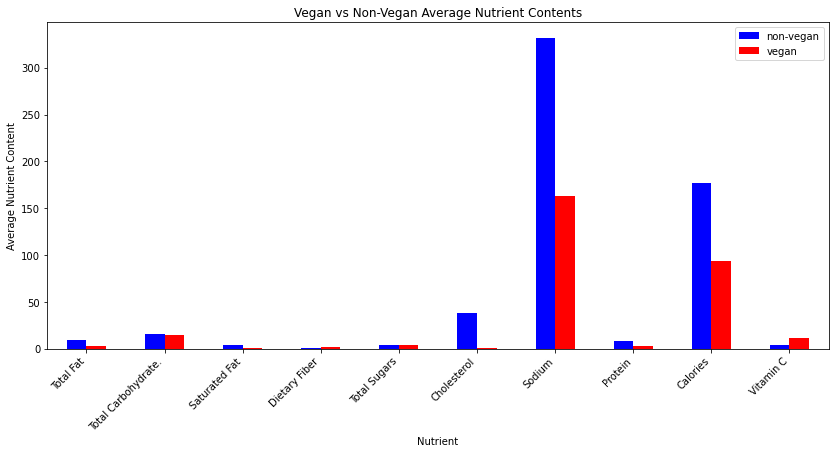

In [11]:
# import numpy for ease of plot configuration
import numpy as np

# get arbitrary x axis positions and tick nums for spacing columns
pos = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
xticks = [p+1 for p in pos]

# record desired vegan/non-vegan bar graph colors and labels
colors = ['blue', 'red']
names = ['non-vegan', 'vegan']

# combine average nutritional contents for plotting
averageContentVals = np.array(list(zip(nonVeganStats.loc["Average Content (units)"], 
                                       veganStats.loc["Average Content (units)"])))

# get plotting vars, create temporary dataframe for data to be plotted
fig, ax = plt.subplots()
tempDf = pd.DataFrame(averageContentVals, index=xticks, columns=names)

# create the plot using pandas' matplotlib integration
ax = tempDf.plot.bar(color=colors, ax=ax, figsize=(14,6))

# add labels and a title
ax.title.set_text('Vegan vs Non-Vegan Average Nutrient Contents')
ax.set_xticklabels(['Total Fat', 'Total Carbohydrate.', 'Saturated Fat', 'Dietary Fiber', \
                    'Total Sugars', 'Cholesterol', 'Sodium', 'Protein', 'Calories', 'Vitamin C'],
                  rotation = 45, ha = 'right')
ax.set_ylabel("Average Nutrient Content")
ax.set_xlabel("Nutrient")

# render the result!
plt.show()

As shown above, the UMD dining hall supply exhibits a significant difference in nutritional content between vegan and non-vegan foods. An apparent nutritional difference means that we could potentially train a model to recognize these differences autonomously. We can hence move on to try and train an "Is Vegan" classifier using our dining hall nutrition data! 

<a id="ml"></a>
# Preparing an "Is Vegan" Classifier

Before we can classify foods by whether or not they are vegan, we need to make several important choices about training data and model parameters. The reason we use only certain nutrition facts to train the model is because there is not a high correlation between every nutritional fact and whether or not the food is vegan. For example, cholesterol is a great way to check if a food is vegan or not because only animal products and byproducts contain cholesterol. However, fiber and vitamin C can [vary greatly](#stats) with every food irrespective of whether the food item is vegan. After training a few models with different features on the UMD dining data itself, we found that we achieved the highest accuracy for vegan classification when using total fat, cholesterol, calories, sodium, and protein as the features. 

Before we get into initial training, we wanted to explain the secondary reason for not using every nutrition fact: and that is the threat of overfitting. Introducing new parameters increases model complexity. This leads to a greater chance of redundancy between input features and increases the likelihood of training on features which don't have any correlation with the desired output. To that end, principal component analysis (PCA) can be used to reduce higher-order feature vectors to more manageable inputs. As this process was not necessary for our use case, we will not be discussing the topic at length; but we do recommend reading up on [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) if you plan to work with more complex models.

All that said, we can try to get an idea of what features will be most relevant to our classifier by taking a look at the correlation between each nutrition fact and whether or not a food is vegan...

In [12]:
# redefine nutrition facts list for clarity
list_of_features = ['Total Fat', 'Total Carbohydrate.', 'Saturated Fat', 'Dietary Fiber', 'Trans Fat',
                    'Total Sugars', 'Cholesterol', 'Sodium', 'Protein', 'Calories', 'Carbohydrates', 
                    'Vitamin C']

# for each nutrition fact...
for feature in list_of_features:
    # calculate correlation coefficient. Print if > .15!
    corrcoef = np.corrcoef(df['Is Vegan'].astype(bool), df[feature])[0][1]
    if abs(corrcoef) > .15:
        print(feature)
        print(corrcoef)

Total Fat
-0.3620866049050871
Saturated Fat
-0.3788608016367718
Cholesterol
-0.33746952452845674
Sodium
-0.2358417899516776
Protein
-0.3787895630591608
Calories
-0.25377245705220525


Based off the above correlation coefficients, it would be a good idea to train our classifier on Total Fat, Saturated Fat, Cholesterol, Sodium, Protein, and Calories. For the sake of demonstration, we're starting with a simple decision tree model to build our classifier. Decision trees break the classification process down into a set of questions (ie. does the food have more than 10 grams of protein) and uses these questions to take an input and ascribe an output label. Decisions trees hence result in an intuitive, easy to describe model which is perfect for our tutorial. Without further ado, we can train and test a decision tree model on the UMD dining hall data to see how accurate our results are using our selected features...

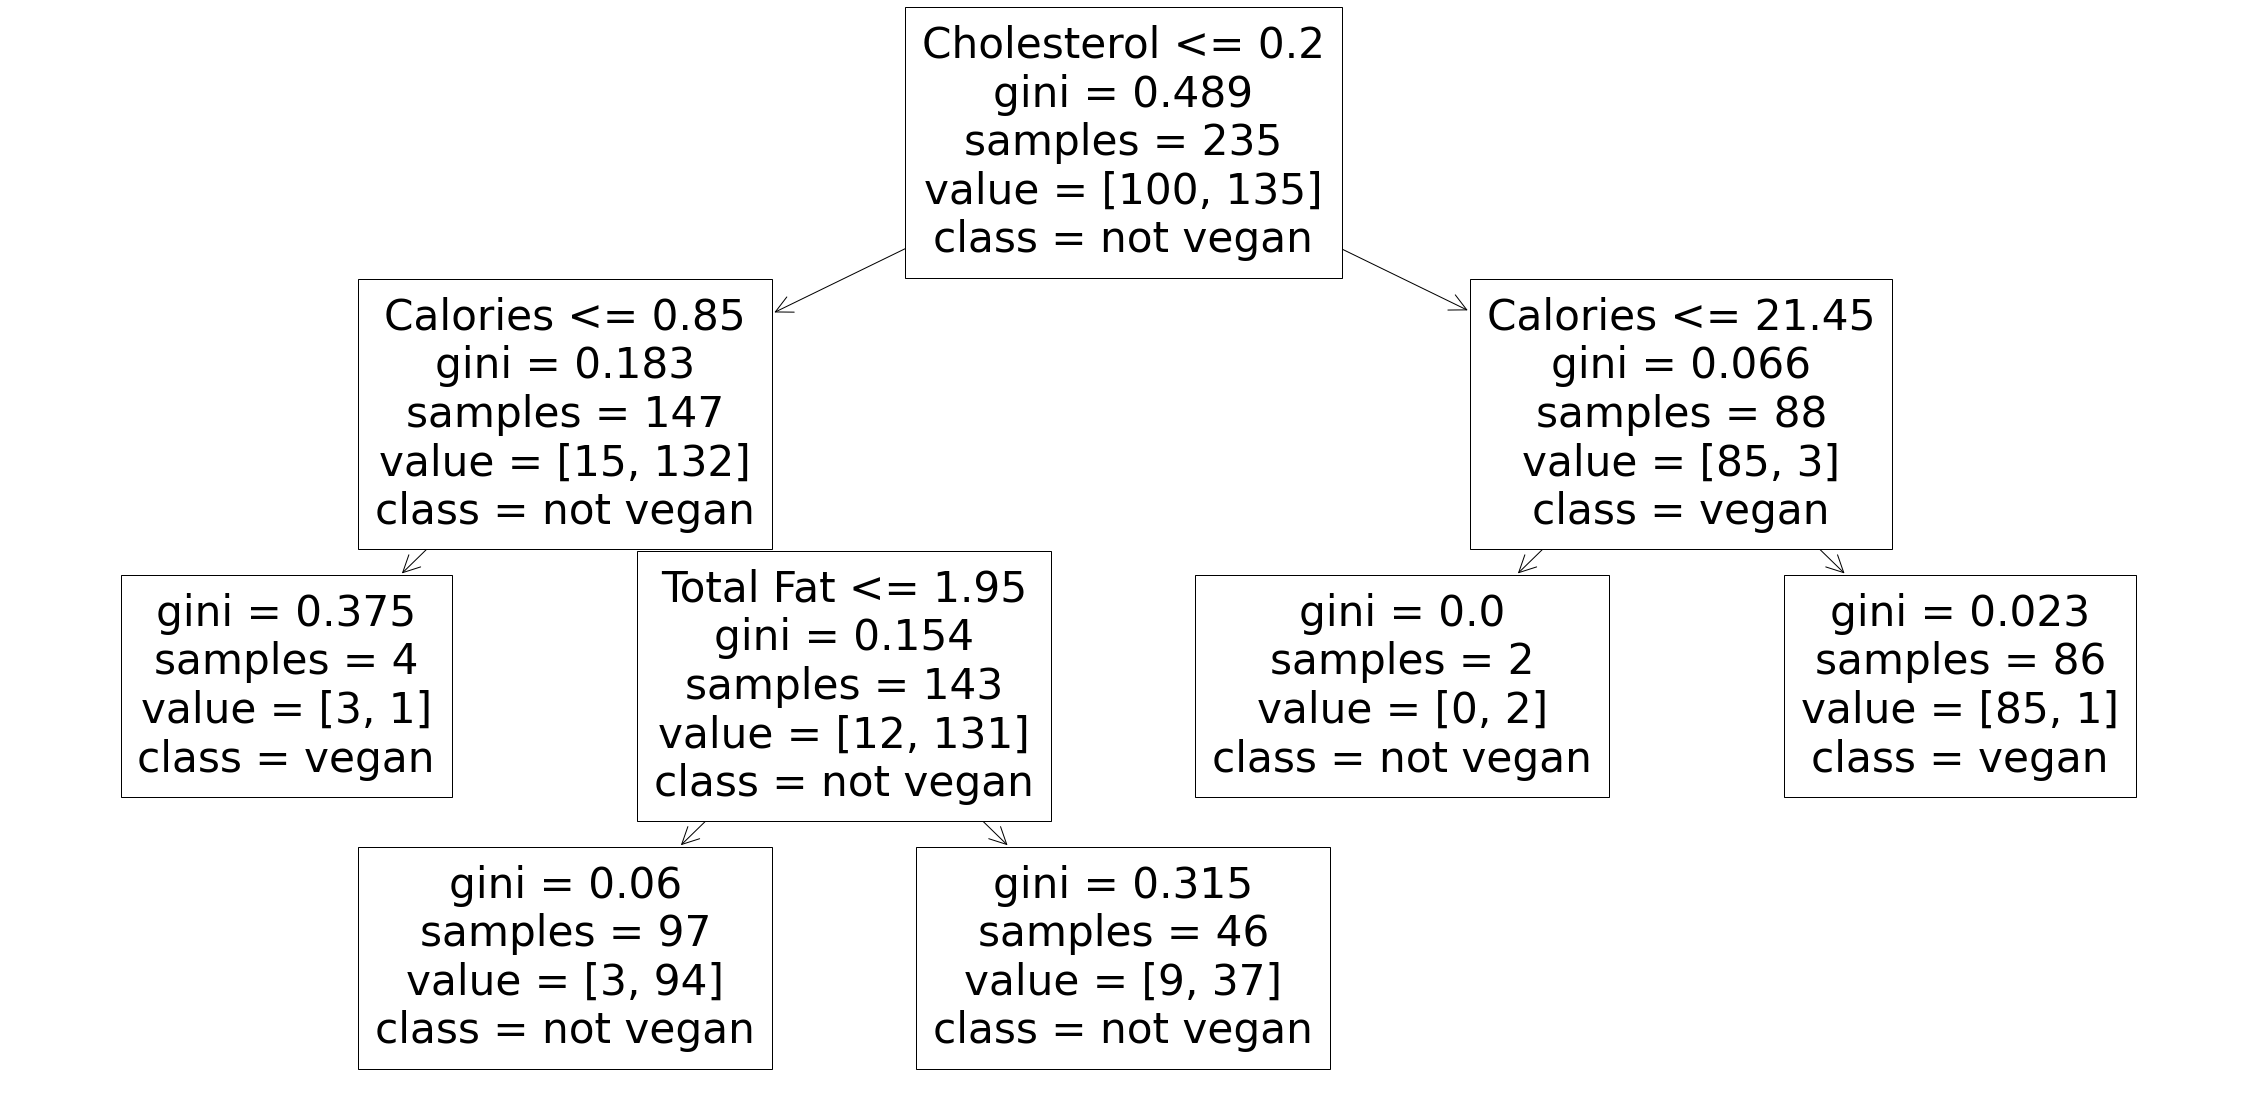

In [13]:
# import scikit-learn libraries for decision tree model
from sklearn import tree
from sklearn import metrics
# and helper libraries for data splitting and analysis
from sklearn.model_selection import train_test_split
from sklearn import discriminant_analysis

# Get input data features (X) and output labels (Y) from UMD nutrition data
tree_X = df.loc[:, ['Total Fat', 'Sodium', 'Protein', 'Calories', 'Cholesterol']]
tree_Y = df['Is Vegan'].astype(bool)

# Divide data into distinct training and holdout validation sets. Fix random state to keep consistent results between runs
tree_X_train, tree_X_test, tree_Y_train, tree_Y_test = train_test_split(tree_X, tree_Y, train_size=.70, random_state = 12)

# Create a decision tree classifier and train it! Limit leaf nodes to keep the result readable
tree_model = tree.DecisionTreeClassifier(random_state = 42, max_leaf_nodes = 5)
tree_model.fit(tree_X_train, tree_Y_train)

# Visualize the tree!
plt.figure(figsize = (40, 20))
_ = tree.plot_tree(tree_model, feature_names = tree_X.columns, class_names = ["vegan", "not vegan"])
plt.show()

The resulting decision tree is actually quite readable! Given any food's nutrition facts, it would be easy to follow along for the resulting classification. With the basic idea demonstrated, let's see if our model can actually classify vegan foods effectively. To that end, we can use the section of our split data that we did not train on (the "validation set") for testing. This approach to model training and testing is known as holdout-validation. In our case, we used 70% of the data to train on and left 30% to test with. We can then get accuracy stats as follows...

In [14]:
# Running predictions on test input set
tree_predicted_Y = tree_model.predict(tree_X_test)

# Printing classification output stats to view strength of model, looks good!
print(metrics.classification_report(tree_Y_test, tree_predicted_Y))

              precision    recall  f1-score   support

       False       1.00      0.83      0.91        35
        True       0.92      1.00      0.96        67

    accuracy                           0.94       102
   macro avg       0.96      0.91      0.93       102
weighted avg       0.95      0.94      0.94       102



## Building a better model
While our the previous decision tree works wonders on our UMD nutrition dataset, it might be too specific to classify non-UMD food samples accurately. Overfitting to training data often leads to this result which is commonly referred to as "generalization loss." To try and produce a model which will generalize better, we can switch to a random forest classifier (which produces a myriad of concurrent decision trees to "vote" on the best classification) instead of just a single decision tree. We can also use [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) (a sorts of recursive holdout-validation used to improve and test models) to demonstrate another approach to model analysis.

In [15]:
# import random forests library and cross validation helper
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# again: select, split up, and store training data!
X = df.loc[ : , ['Total Fat', 'Sodium', 'Protein', 'Calories', 'Cholesterol']]
Y = df['Is Vegan'].astype(bool)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 13)

# prepare random forest models 
clf1=RandomForestClassifier(n_estimators=1000, random_state = 10)
clf2=RandomForestClassifier(n_estimators=1000, random_state = 10)

# apply 10-fold cross validation!
rforestScores = cross_val_score(clf1, X, Y, cv = 10)
print(rforestScores)
print("Average accuracy score from cross-validation: ", rforestScores.mean())

# and get accuracy from holdout validation
clf2.fit(X_train, Y_train)
y_pred = clf2.predict(X_test)
print("Holdout validation accuracy: ", metrics.accuracy_score(Y_test, y_pred))

[0.94117647 0.91176471 0.97058824 0.91176471 0.94117647 0.91176471
 0.94117647 0.96969697 1.         0.93939394]
Average accuracy score from cross-validation:  0.9438502673796793
Holdout validation accuracy:  0.9411764705882353


After running the above code several times with varying test sizes, we found that we were able to consistently achieve around 94% accuracy with our selected features using 10-fold cross validation. With our holdout validation set achieving similar results (using a 70-30 split), we were satisfied with this result and decided it was time to run our model on some non-UMD food samples.

## Finding a generalization test data set and cleaning it

To see how our classifier works in the wild, we need to get new test data. We were able to find a decent nutrition dataset on [Kaggle](https://www.kaggle.com/trolukovich/nutritional-values-for-common-foods-and-products) for testing our classifier on. It contained all of the input features we had used for training, and it also provided descriptive names which we can use to manually decide if the foods are vegan. We hence begin the generalization prediction process by cleaning up this new dataset...

In [23]:
# start by reading in downloaded csv
new_data = pd.read_csv("nutrition.csv", sep=',')

# select relevant features
new_data = new_data.loc[:,['name', 'total_fat', 'sodium', 'protein', 'calories', 'cholesterol']]

# remove units from data
new_data['total_fat'] = new_data.total_fat.str.replace('g' , '')
new_data['protein'] = new_data.protein.str.replace(' g' , '')
new_data['sodium'] = new_data.sodium.str.replace('mg' , '')
new_data['cholesterol'] = new_data.cholesterol.str.replace('mg' , '')

# rename almond milk because it is the only string including " milk" which is vegan
new_data['name'] = new_data.name.str.replace('almond milk' , 'almondmilk')

# rename columns for ease of interpretation
new_data.rename(columns = {'cholesterol' : 'Cholesterol', 'total_fat' : 'Total Fat', 'calories' : 'Calories', 'protein' : 'Protein', 'sodium' : 'Sodium'}, inplace = True)
new_data.head()

,name,Total Fat,Sodium,Protein,Calories,Cholesterol
0,Cornstarch,0.1,9.00,0.26,381,0
1,"Nuts, pecans",72,0.00,9.17,691,0
2,"Eggplant, raw",0.2,2.00,0.98,25,0
3,"Teff, uncooked",2.4,12.00,13.30,367,0
4,"Sherbet, orange",2,46.00,1.10,144,1


We can then prepare a string block list to manually classify whether or not each food is vegan for measuring the accuracy of our classifier. To keep things manageable, we can also trim our test data set down to a hundred or so entries. 

In [24]:
# list of non-vegan food indicators
non_vegan_words = ['pork', 'beef', 'honey', 'turkey', 'lamb','fish', 'veal', 'egg', 
                   'pepperoni', 'chicken', 'meat', 'steak', 'cheese', ' milk', 'dulce', 
                   'gravy', 'chocolate chip']
# column of is/isn't vegan labels
new_data['Actually Vegan'] = ''

# loop through foods, assign them vegan/non-vegan
for index, name in zip(new_data.index, new_data['name']):
    if any(non_veg in name.lower() for non_veg in non_vegan_words):
        new_data.at[index, 'Actually Vegan'] = False
    else:
        new_data.at[index, 'Actually Vegan'] = True 
        
# trim to 100 entries
trimmed_data = new_data.sample(n=100, random_state=23)
trimmed_data.reset_index(drop=True, inplace=True)
trimmed_data

,name,Total Fat,Sodium,Protein,Calories,Cholesterol,Actually Vegan
0,"Alcoholic beverage, dry, dessert, wine",0,9.00,0.20,152,0,True
1,"Pork, raw, salt pork, cured",81,2684.00,5.05,748,86,False
2,"Soup, chunk style, low sodium, beef and mushroom",2.3,25.00,4.30,69,6,False
3,"Bratwurst, smoked, lite, beef and turkey, pork",14,982.00,14.45,186,56,False
4,"Lamb, fast fried, cooked, separable lean only,...",4.8,59.00,27.94,155,94,False
...,...,...,...,...,...,...,...
95,"Fast foods, lettuce and tomato, steak and chee...",5.3,444.00,12.29,183,24,False
96,"Beverages, shelf stable, unsweetened, almondmilk",1.1,71.00,0.59,15,0,True
97,"Beef, raw, select, trimmed to 0"" fat, separabl...",6.7,46.00,22.79,151,63,False
98,"Beet greens, raw",0.1,226.00,2.20,22,0,True


## Generalization error estimation
Now that we have a test dataset ready to go, we can start seeing how well our model does (or does not) generalize! To do so, we should call our old UMD-trained model on the external dataset. After recording our model's predictions, we can compare them with our manual vegan classifications from earlier. We can see how accurate our model turned out to be in terms of which labels did not line up  (between the prediction and manual vegan classification columns)...

In [25]:
# select input features from generalization test set
X = trimmed_data.loc[ : , ['Total Fat', 'Sodium', 'Protein', 'Calories', 'Cholesterol']]
Y = trimmed_data['Actually Vegan'].astype(bool)

# make predictions using our pretrained model!
y_pred = clf2.predict(X)
trimmed_data['Is Vegan'] = y_pred

# return any incorrect classifications
trimmed_data[trimmed_data['Is Vegan'] != trimmed_data['Actually Vegan']]

,name,Total Fat,Sodium,Protein,Calories,Cholesterol,Actually Vegan,Is Vegan
33,"MURRAY, Honey Graham",13,477.00,5.90,445,0,False,True
35,"Babyfood, without added fluoride., GERBER, bot...",0,0.00,0.00,0,0,True,False
41,"Beverages, with added nutrients, powder, choco...",2.3,136.00,4.55,400,0,False,True
43,"Margarine-like, with added vitamin D, with sal...",60,785.00,0.17,533,1,True,False
51,"Cereals ready-to-eat, QUAKER Honey Graham LIFE...",4.1,488.00,9.33,373,0,False,True
72,"Cereals ready-to-eat, honey roasted, HONEY BUN...",5.5,454.00,7.12,401,0,False,True
75,"Syrups, fudge-type, chocolate",8.9,346.00,4.60,350,1,True,False
89,"Cereals ready-to-eat, with real strawberries, ...",4.9,410.00,6.70,399,0,False,True
91,"Infant formula, with ARA and DHA, SENSITIVE (L...",3.7,21.00,1.48,68,2,True,False


After looking at for mismatch between the is-vegan prediction and the labels we had created, we can see that there is some uncertainty with a couple foods. Specifically, there is no way to know whether or not the infant formulas, chocolate milk mix, margarine, or chocolate syrup are vegan. For this reason, we have decided to drop them from our output.

In [26]:
trimmed_data.drop([35, 41, 43, 75, 91], axis = 0, inplace = True)
trimmed_data[trimmed_data['Is Vegan'] != trimmed_data['Actually Vegan']]

,name,Total Fat,Sodium,Protein,Calories,Cholesterol,Actually Vegan,Is Vegan
33,"MURRAY, Honey Graham",13,477.00,5.90,445,0,False,True
51,"Cereals ready-to-eat, QUAKER Honey Graham LIFE...",4.1,488.00,9.33,373,0,False,True
72,"Cereals ready-to-eat, honey roasted, HONEY BUN...",5.5,454.00,7.12,401,0,False,True
89,"Cereals ready-to-eat, with real strawberries, ...",4.9,410.00,6.70,399,0,False,True


After dropping the data above, we can see that we are left with four false positives of food being labeled as vegan when they are not. All of the mislabled foods are ones that contain honey. This would be difficult to accurately classify as vegan since it the only nutritional value that honey affects is sugar. We do not use sugar in our classifier since it is not generally an accurate indicator of a food being vegan, and thus we fail to classify foods that are only not vegan because of them containing honey.  

In [27]:
print("Accuracy:", metrics.accuracy_score(trimmed_data['Actually Vegan'].astype(bool), 
                                          trimmed_data['Is Vegan'].astype(bool)))

Accuracy: 0.9578947368421052


We can see that our classifer generally worked well with a 96% accuracy. The only false positives are for four foods that contain honey. We have no false negatives, meaning that all food that is vegan was properly classified as such.